In [110]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import joblib
import itertools
import random

# seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# -------------------------------
# Step 1: Load Data and Artifacts
# -------------------------------
X_train_df = pd.read_csv("preprocessed_data/X_train.csv")
y_train_df = pd.read_csv("preprocessed_data/y_train.csv")

scaler = joblib.load("preprocessed_data/standard_scaler.pkl")
cat_vocab = joblib.load("preprocessed_data/cat_vocab.pkl")
cat_mapping = joblib.load("preprocessed_data/cat_mapping.pkl")
print("Loaded StandardScaler and categorical artifacts.")

# -------------------------------
# Step 2: Define Feature Lists
# -------------------------------
numeric_features = ['amt', 'city_pop', 'age', 'hour', 'day', 'month', 'weekday', 'distance', 'lat', 'long', 'merch_lat', 'merch_long']
cat_features = ['merchant', 'category', 'gender', 'state', 'city', 'job']

# -------------------------------
# Step 3: Filter Data for Fraud Cases and Non-Fraud Cases
# -------------------------------
y_train = y_train_df.iloc[:, 0]
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

X_train_num = X_train_df[numeric_features].loc[fraud_mask].values
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values
X_nonfraud_num = X_train_df[numeric_features].loc[nonfraud_mask].values

# -------------------------------
# Step 4: Engineered Features (time features)
# -------------------------------
eng_features = ['hour', 'day', 'month', 'weekday', 'distance']
eng_indices = [numeric_features.index(feat) for feat in eng_features]

eng_min_np = np.min(X_train_num[:, eng_indices], axis=0)
eng_max_np = np.max(X_train_num[:, eng_indices], axis=0)
eng_min = torch.tensor(eng_min_np, dtype=torch.float32)
eng_max = torch.tensor(eng_max_np, dtype=torch.float32)
print("Engineered features - observed min:", eng_min_np, "max:", eng_max_np)

# -------------------------------
# Step 5: Create Dataset and DataLoader
# -------------------------------
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data, cat_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
    def __len__(self):
        return self.num_data.shape[0]
    def __getitem__(self, idx):
        return self.num_data[idx], self.cat_data[idx]

fraud_dataset = SparkovFraudDataset(X_train_num, X_train_cat)
loader = DataLoader(fraud_dataset, batch_size=40, shuffle=True)

# -------------------------------
# Step 6: Set Device and Diffusion Hyperparameters
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

T_train = 800
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0).to(device)

# Compute non-fraud statistics for prior loss
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5

# Loss weight parameters
w1 = 0.15
w2 = 0.55

# -------------------------------
# Step 7: Define Loss Functions and Forward Diffusion
# -------------------------------
def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_Lnorm(pred_noise, true_noise):
    return F.mse_loss(pred_noise, true_noise)

def compute_Lprior(pred_noise):
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0, 1)
    prob = 1 - normal.cdf(z_abs)
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

def engineered_range_loss(x0_est_eng, eng_min, eng_max):
    lower_penalty = F.relu(eng_min - x0_est_eng)
    upper_penalty = F.relu(x0_est_eng - eng_max)
    return torch.mean(lower_penalty + upper_penalty)

# -------------------------------
# Step 8: Define the Model (CombinedNoisePredictor)
# -------------------------------
class CombinedNoisePredictor(nn.Module):
    def __init__(self, num_input_dim, cat_vocab_sizes, cat_embed_dim=20, hidden_dim=256):
        super(CombinedNoisePredictor, self).__init__()
        self.embeddings = nn.ModuleDict()
        for col, vocab in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab, cat_embed_dim)
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        combined_input_dim = num_input_dim + cat_total_dim
        self.fc1 = nn.Linear(combined_input_dim + 1, hidden_dim)  # +1 for timestep
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, combined_input_dim)
        self.activation = nn.LeakyReLU()
        
    def forward(self, x_num, x_cat, t):
        embeds = []
        for i, col in enumerate(self.embeddings):
            emb = self.embeddings[col](x_cat[:, i])
            embeds.append(emb)
        x_cat_emb = torch.cat(embeds, dim=1)
        x = torch.cat([x_num, x_cat_emb], dim=1)
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

Loaded StandardScaler and categorical artifacts.
Engineered features - observed min: [-1.87890062 -1.67309039 -1.79624861 -1.3500817  -2.58862707] max: [1.49563575 1.70671805 1.41547433 1.37969415 2.31907895]
Using device: cpu


In [ ]:
best_config = {'lr': 0.001, 'hidden_dim': 256, 'cat_embed_dim': 20, 'lambda_eng': 0.4
               }

In [112]:
print("Training final model with best configuration:", best_config)

# Instantiate the final model using the best hyperparameters
final_model = CombinedNoisePredictor(
    num_input_dim=len(numeric_features),
    cat_vocab_sizes={col: cat_vocab[col] for col in cat_features},
    cat_embed_dim=best_config['cat_embed_dim'],
    hidden_dim=best_config['hidden_dim']
).to(device)

final_optimizer = optim.Adam(final_model.parameters(), lr=best_config['lr'])

# Define the number of epochs for final training (e.g., 250 epochs)
final_epochs = 250

for epoch in range(final_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x0_num, x0_cat = batch
        x0_num = x0_num.to(device)
        x0_cat = x0_cat.to(device)
        batch_size = x0_num.shape[0]
        
        # Sample random timesteps for diffusion
        t = torch.randint(0, T_train, (batch_size,), device=device)
        x_t_num, true_noise = forward_diffusion(x0_num, t)
        pred_noise = final_model(x_t_num, x0_cat, t)
        pred_noise_numeric = pred_noise[:, :len(numeric_features)]
        
        L_norm = compute_Lnorm(pred_noise_numeric, true_noise)
        L_prior = compute_Lprior(pred_noise_numeric)
        
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        x0_est = (x_t_num - sqrt_one_minus_alpha_hat_t * pred_noise_numeric) / sqrt_alpha_hat_t
        
        neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size,), device=device)
        negative_sample = X_nonfraud_tensor[neg_indices]
        L_triplet = triplet_loss(x0_est, x0_num, negative_sample)
        
        # Engineered range loss for engineered features (hour, day, month, weekday)
        x0_est_eng = x0_est[:, eng_indices]
        L_eng = engineered_range_loss(x0_est_eng, eng_min.to(device), eng_max.to(device))
        
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet + best_config['lambda_eng'] * L_eng
        final_optimizer.zero_grad()
        total_loss.backward()
        final_optimizer.step()
        epoch_loss += total_loss.item()
    
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch+1}/{final_epochs}], Loss: {avg_loss:.4f}")

# Save the final trained model
torch.save(final_model.state_dict(), "fraud_diffuse_model_final.pth")
print("Final model training complete and saved as 'fraud_diffuse_model_final.pth'.")

Training final model with best configuration: {'lr': 0.001, 'hidden_dim': 256, 'cat_embed_dim': 20, 'lambda_eng': 0.4}
Epoch [1/250], Loss: 2.0917
Epoch [2/250], Loss: 1.0267
Epoch [3/250], Loss: 0.9079
Epoch [4/250], Loss: 0.8104
Epoch [5/250], Loss: 0.7575
Epoch [6/250], Loss: 0.7304
Epoch [7/250], Loss: 0.6786
Epoch [8/250], Loss: 0.7033
Epoch [9/250], Loss: 0.6607
Epoch [10/250], Loss: 0.6466
Epoch [11/250], Loss: 0.6524
Epoch [12/250], Loss: 0.6322
Epoch [13/250], Loss: 0.6197
Epoch [14/250], Loss: 0.6059
Epoch [15/250], Loss: 0.6026
Epoch [16/250], Loss: 0.5870
Epoch [17/250], Loss: 0.5840
Epoch [18/250], Loss: 0.5833
Epoch [19/250], Loss: 0.5564
Epoch [20/250], Loss: 0.5563
Epoch [21/250], Loss: 0.5438
Epoch [22/250], Loss: 0.5523
Epoch [23/250], Loss: 0.5533
Epoch [24/250], Loss: 0.5485
Epoch [25/250], Loss: 0.5503
Epoch [26/250], Loss: 0.5434
Epoch [27/250], Loss: 0.5376
Epoch [28/250], Loss: 0.5402
Epoch [29/250], Loss: 0.5144
Epoch [30/250], Loss: 0.5085
Epoch [31/250], Loss

Synthetic numeric samples shape (normalized): torch.Size([1000, 12])
Synthetic categorical samples shape: torch.Size([1000, 6])
Real Fraud Numeric Statistics (Original Scale):
               amt     city_pop          age          hour          day  \
count  6273.000000  6273.000000  6273.000000  6.273000e+03  6273.000000   
mean      5.553833     8.427249    48.933842  1.396126e+01    15.704448   
std       1.627878     2.443052    18.723719  9.707241e+00     8.773403   
min       0.722706     3.178054    14.000000  3.545246e-08     1.000001   
25%       5.479722     6.679599    33.000000  2.000000e+00     8.000000   
50%       5.958528     7.940228    48.000000  2.200000e+01    15.000000   
75%       6.802939     9.893640    61.000000  2.300000e+01    23.000000   
max       7.227692    14.882529    96.000000  2.300000e+01    31.000000   

             month       weekday     distance          lat         long  \
count  6273.000000  6.273000e+03  6273.000000  6273.000000  6273.000000  

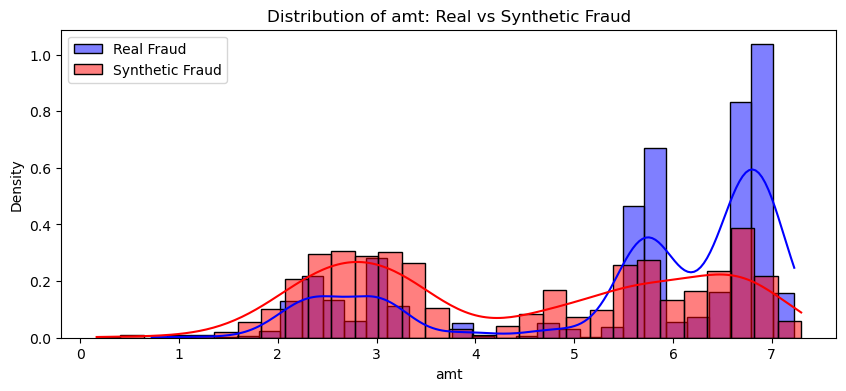

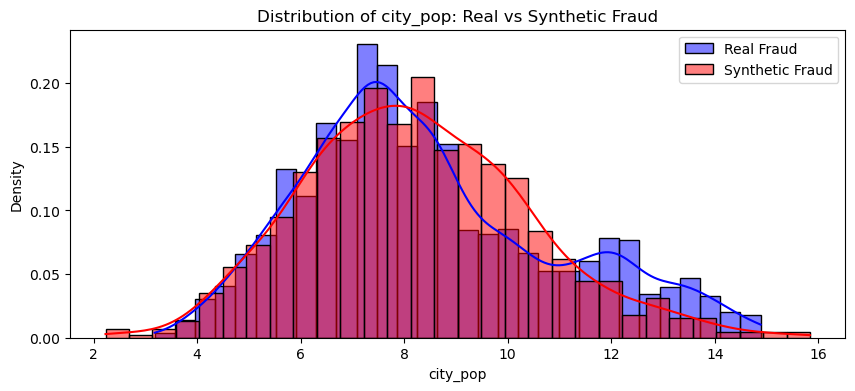

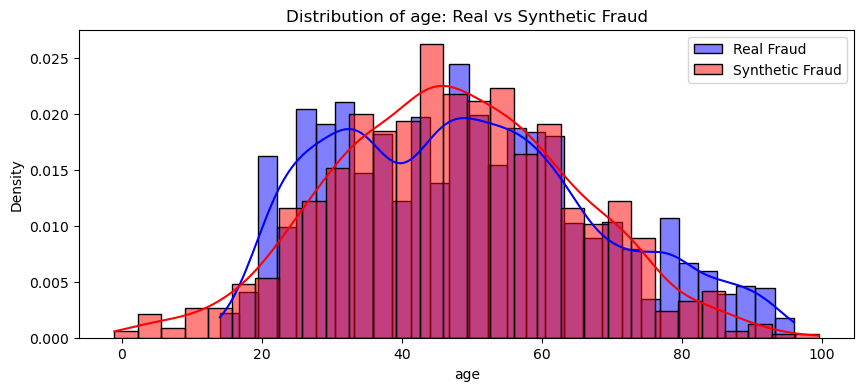

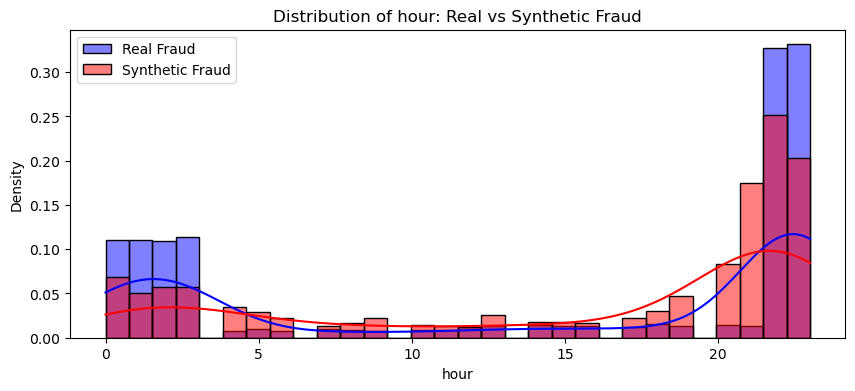

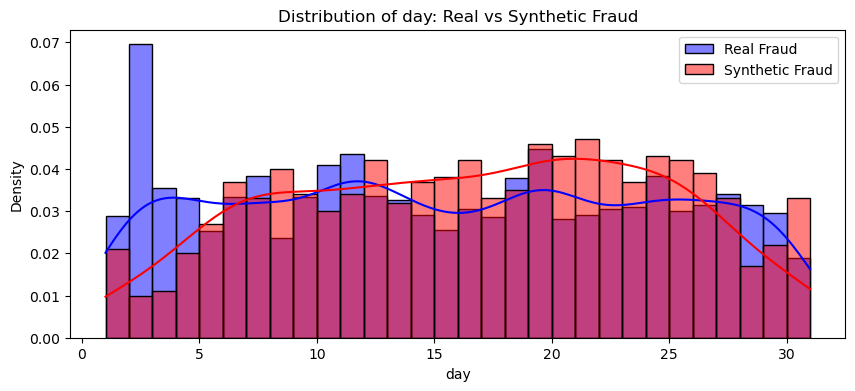

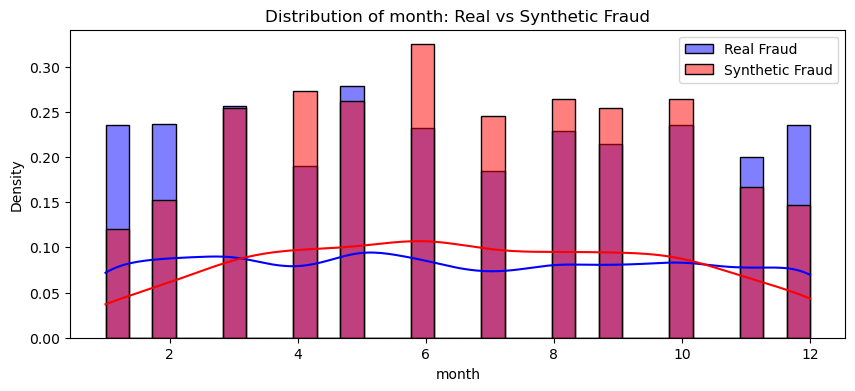

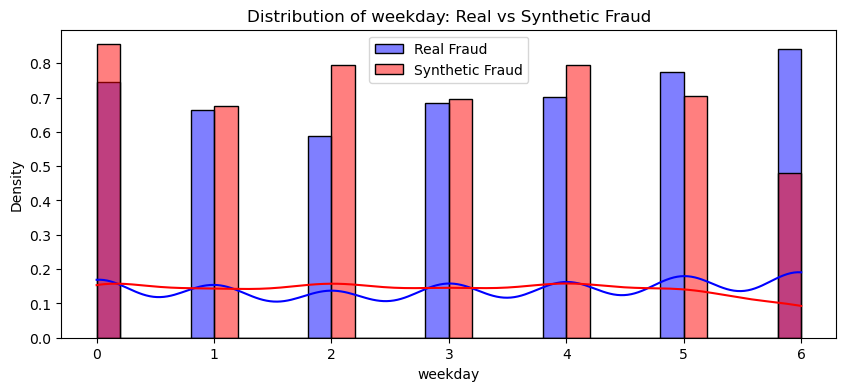

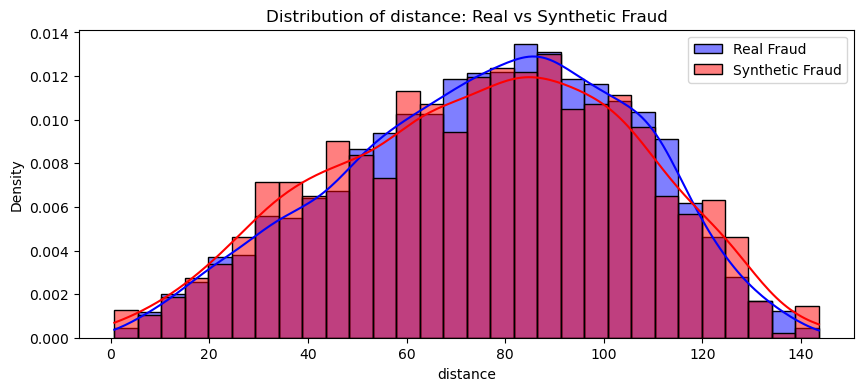

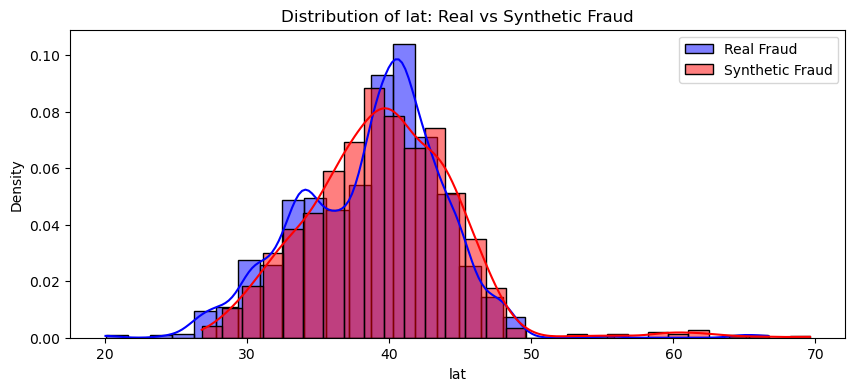

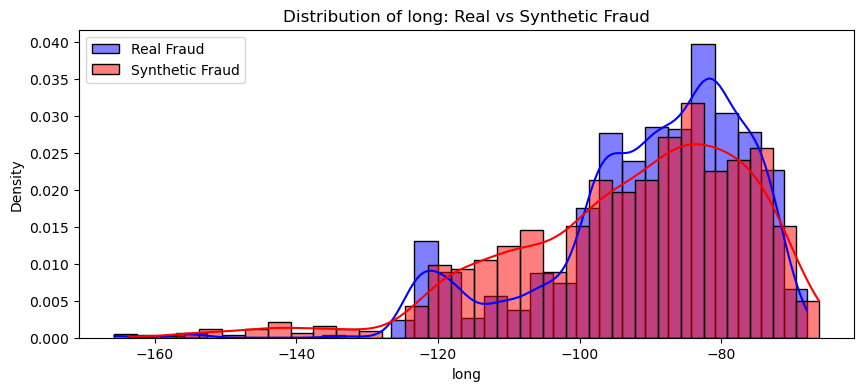

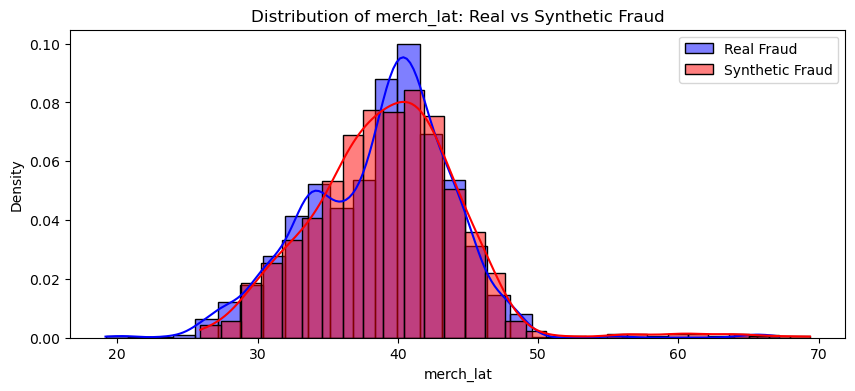

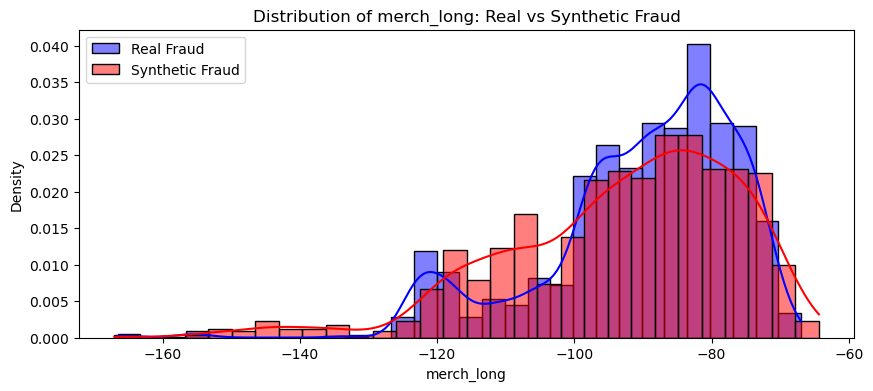

In [113]:
#############################################
# Step 10: Generate Synthetic Fraud Samples via Reverse Diffusion
#############################################
def generate_synthetic_fraud(model, num_samples, T_gen=T_train):
    model.eval()
    with torch.no_grad():
        # For categorical features, generate random integer codes based on each feature's vocabulary size.
        cat_vocab_sizes = {col: cat_vocab[col] for col in cat_features}
        cat_samples = {}
        for col in cat_vocab_sizes:
            vocab_size = cat_vocab_sizes[col]
            cat_samples[col] = torch.randint(0, vocab_size, (num_samples,), device=device, dtype=torch.long)
        # Stack categorical samples into one tensor.
        x_cat = torch.stack([cat_samples[col] for col in cat_features], dim=1)
        
        # Define the number of numeric input features.
        num_input_dim = len(numeric_features)
        # Create an initial numeric tensor using statistics from the real fraud data.
        X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32).to(device)
        noise = torch.randn(num_samples, num_input_dim).to(device)
        x_t_num = X_fraud_tensor.mean(dim=0, keepdim=True).repeat(num_samples, 1) + \
                  X_fraud_tensor.std(dim=0, keepdim=True).repeat(num_samples, 1) * noise
        
        # Reverse diffusion process.
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            pred_noise = model(x_t_num, x_cat, t)
            pred_noise_numeric = pred_noise[:, :num_input_dim]
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            z = torch.randn_like(x_t_num) if t_step > 1 else torch.zeros_like(x_t_num)
            x_t_num = (x_t_num - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise_numeric) / sqrt_alpha_t \
                      + torch.sqrt(beta_t) * z
        
        # After reverse diffusion, clip engineered features to the observed range.
        x_t_num_clipped = x_t_num.clone()
        x0_est_eng = x_t_num[:, eng_indices]
        x0_est_eng = torch.max(torch.min(x0_est_eng, eng_max.unsqueeze(0)), eng_min.unsqueeze(0))
        x_t_num_clipped[:, eng_indices] = x0_est_eng
        
        return x_t_num_clipped, x_cat

# Generate synthetic samples using the final trained model.
num_synthetic = 1000
synthetic_num_norm, synthetic_cat = generate_synthetic_fraud(final_model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat.shape)




#############################################
# Step 11: Inverse Transform Numeric Features to Original Scale
#############################################
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

#############################################
# Step 12: Combine Numeric and Categorical Parts and Evaluate
#############################################
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrames for synthetic data.
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
#round engineered time features 
synthetic_numeric_df['month'] = synthetic_numeric_df['month'].round().clip(1, 12)
synthetic_numeric_df['day'] = synthetic_numeric_df['day'].round().clip(1, 31)  # adjust range if necessary
synthetic_numeric_df['hour'] = synthetic_numeric_df['hour'].round().clip(0, 23)
synthetic_numeric_df['weekday'] = synthetic_numeric_df['weekday'].round().clip(0, 6)

synthetic_cat_df = pd.DataFrame(synthetic_cat.cpu().numpy(), columns=cat_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

# Also create a DataFrame for the real fraud data (inverse transformed).
X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_numeric = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_numeric, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

# Plot the distributions of each numeric feature to compare real vs. synthetic data.
for col in numeric_features:
    plt.figure(figsize=(10,4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic Fraud")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()



Feature: amt
  KS Statistic: 0.3776, p-value: 0.0000
  Wasserstein Distance: 1.1207
  Jensen-Shannon Divergence: 0.3610


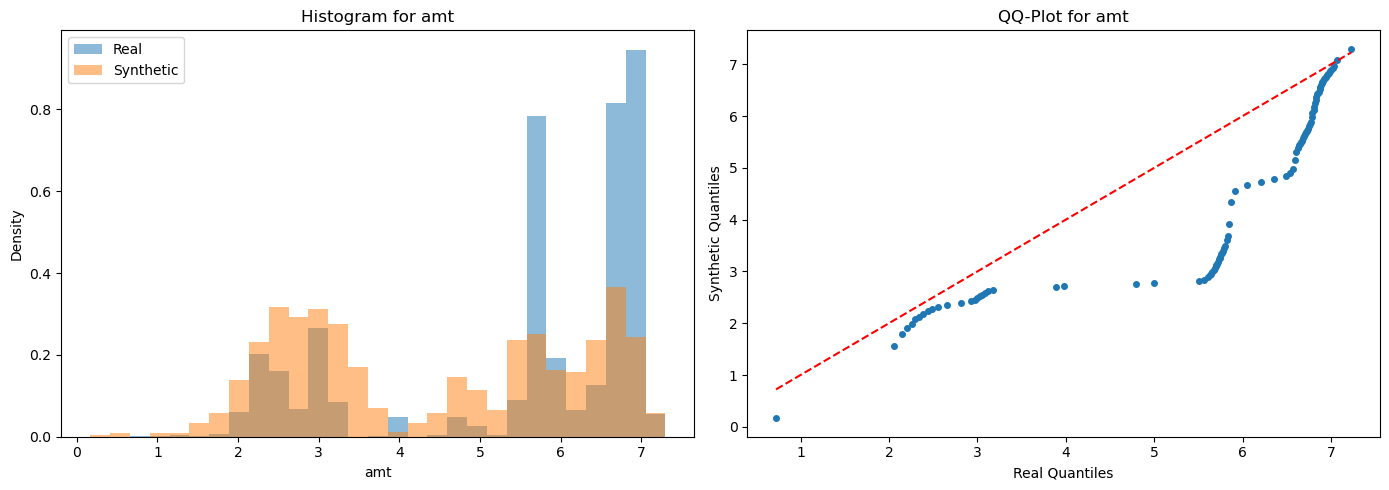


Feature: city_pop
  KS Statistic: 0.0831, p-value: 0.0000
  Wasserstein Distance: 0.2841
  Jensen-Shannon Divergence: 0.1473


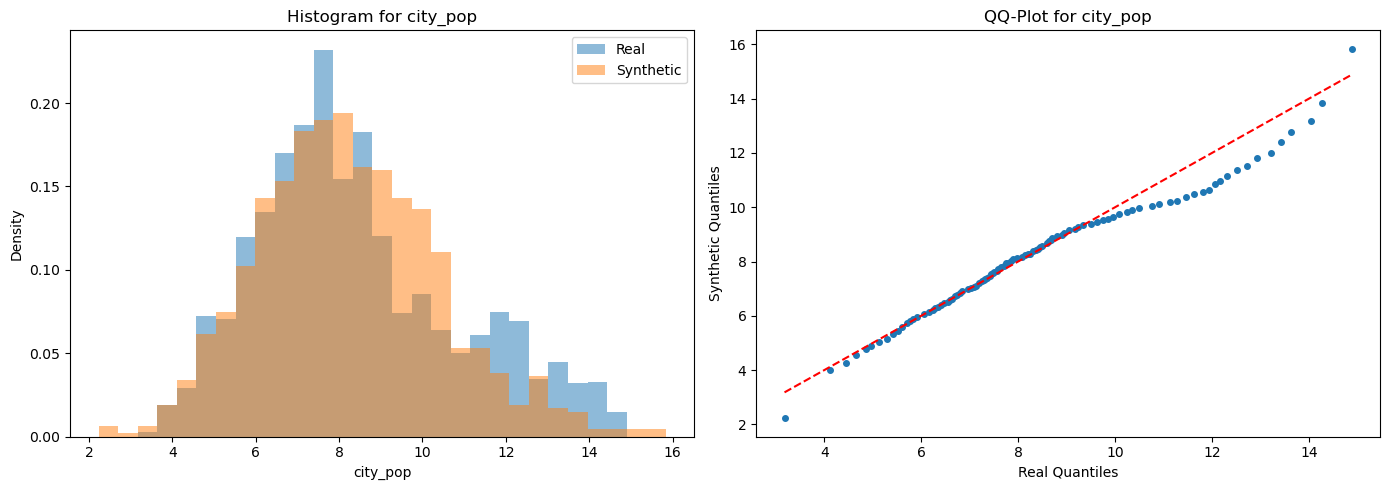


Feature: age
  KS Statistic: 0.0667, p-value: 0.0009
  Wasserstein Distance: 2.5623
  Jensen-Shannon Divergence: 0.1731


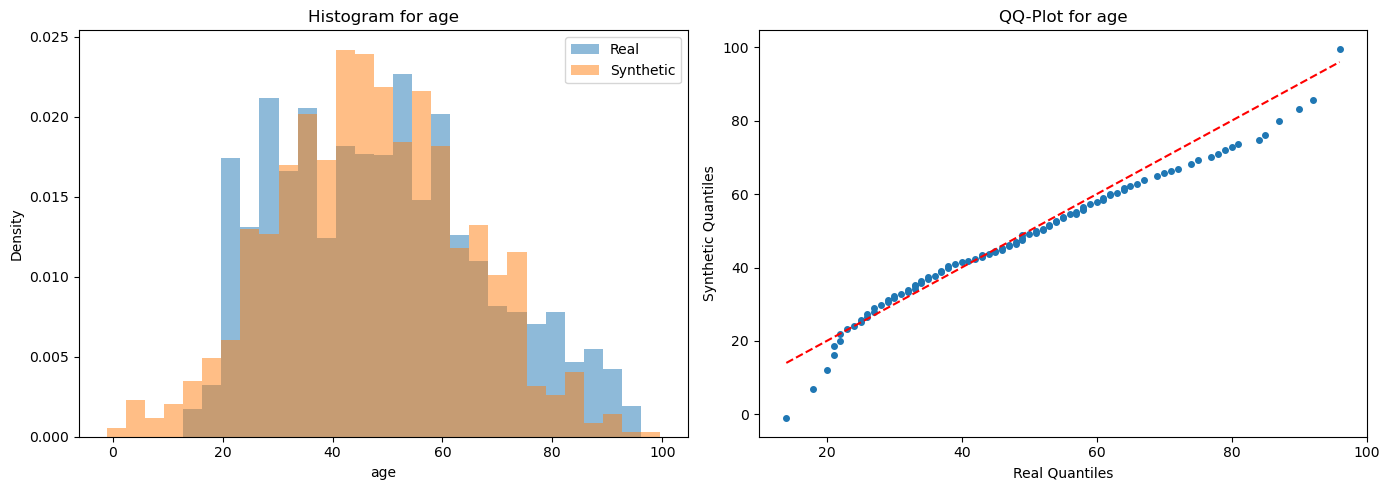


Feature: hour
  KS Statistic: 0.1605, p-value: 0.0000
  Wasserstein Distance: 2.0348
  Jensen-Shannon Divergence: 0.2820


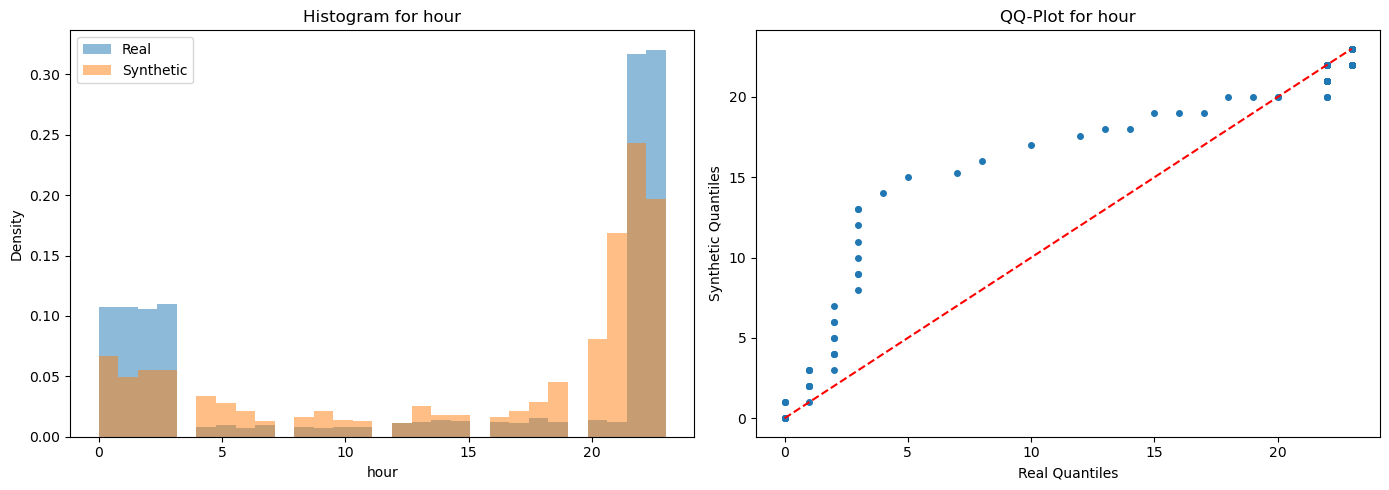


Feature: day
  KS Statistic: 0.1050, p-value: 0.0000
  Wasserstein Distance: 1.2365
  Jensen-Shannon Divergence: 0.1262


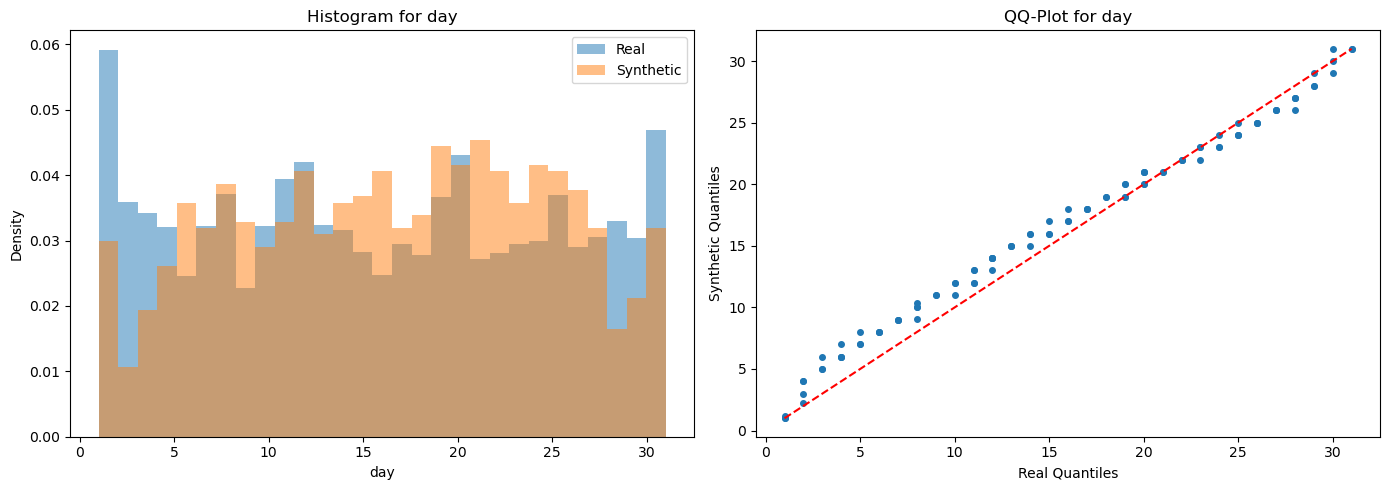


Feature: month
  KS Statistic: 0.1672, p-value: 0.0000
  Wasserstein Distance: 0.4363
  Jensen-Shannon Divergence: 0.1080


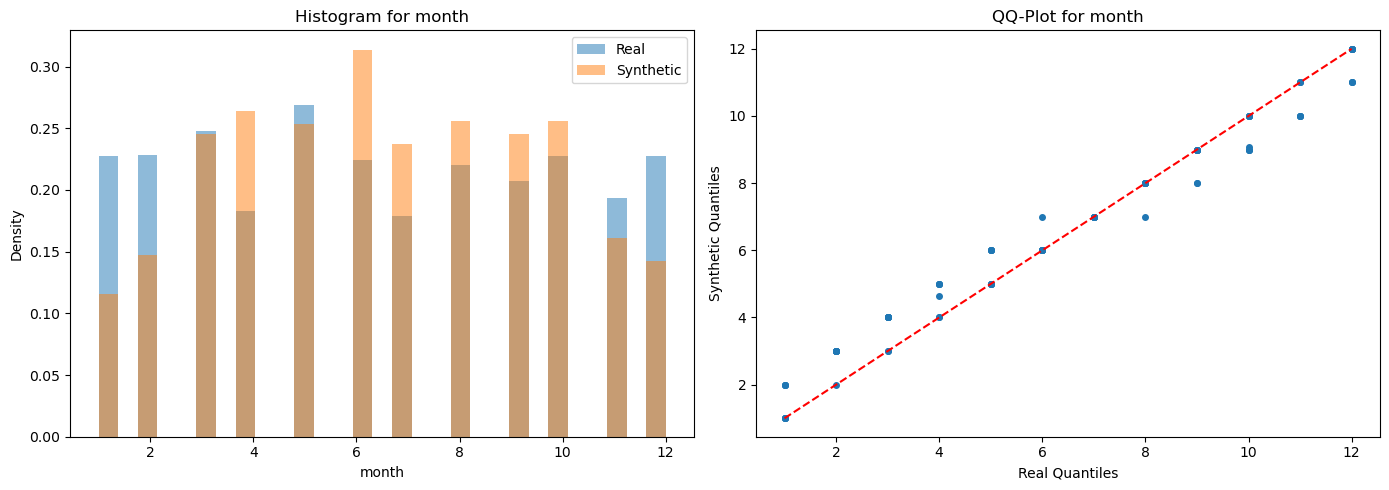


Feature: weekday
  KS Statistic: 0.1710, p-value: 0.0000
  Wasserstein Distance: 0.3370
  Jensen-Shannon Divergence: 0.0859


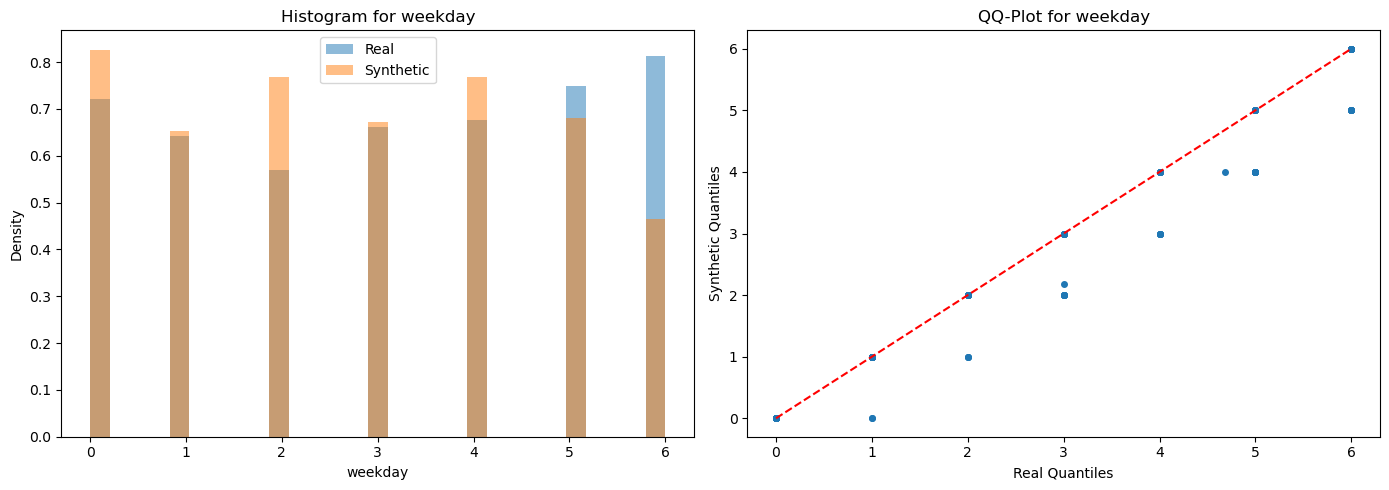


Feature: distance
  KS Statistic: 0.0364, p-value: 0.1981
  Wasserstein Distance: 1.6403
  Jensen-Shannon Divergence: 0.0842


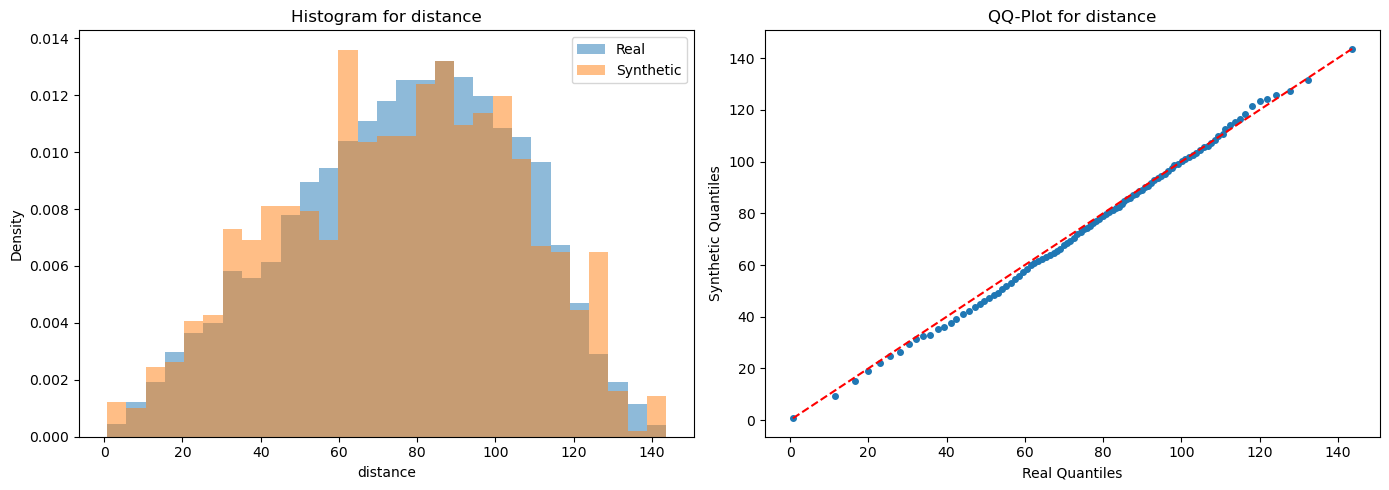


Feature: lat
  KS Statistic: 0.0714, p-value: 0.0003
  Wasserstein Distance: 0.7823
  Jensen-Shannon Divergence: 0.1379


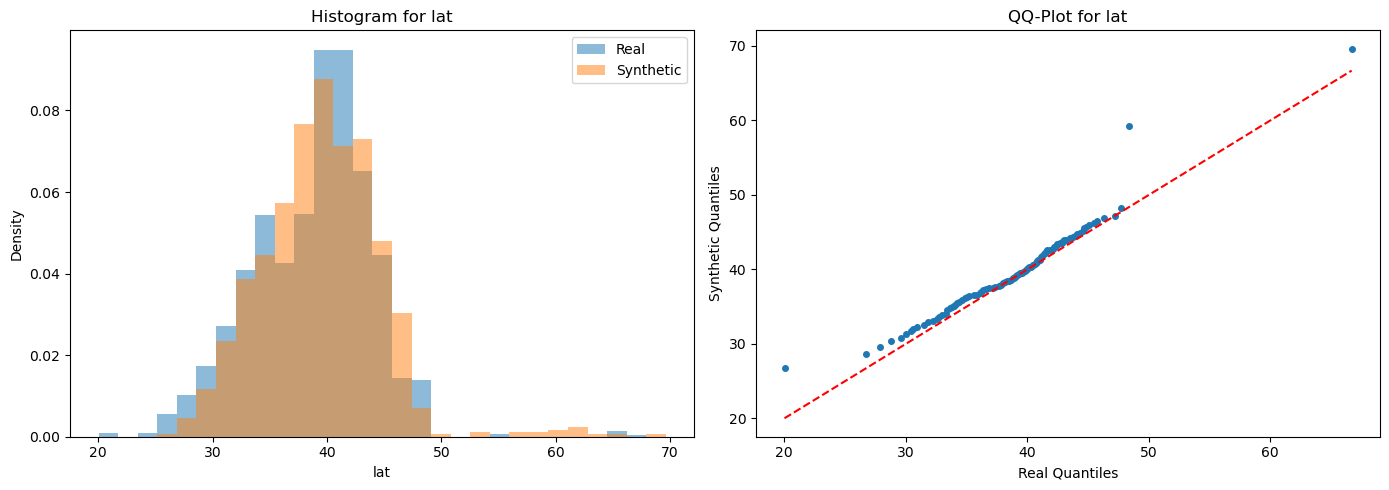


Feature: long
  KS Statistic: 0.1135, p-value: 0.0000
  Wasserstein Distance: 3.0329
  Jensen-Shannon Divergence: 0.1708


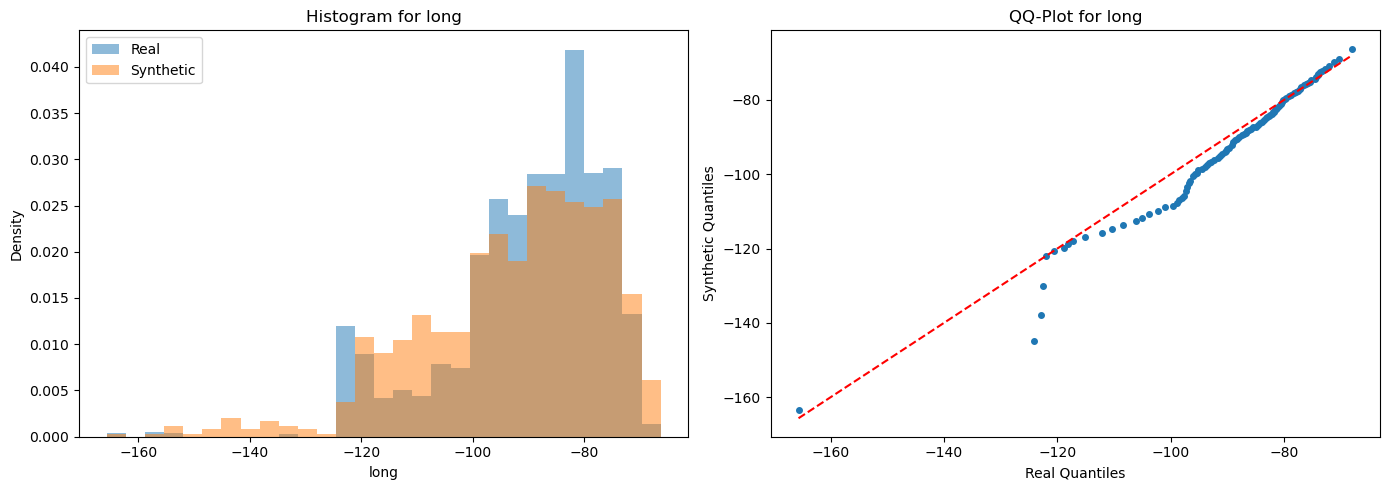


Feature: merch_lat
  KS Statistic: 0.0524, p-value: 0.0169
  Wasserstein Distance: 0.5539
  Jensen-Shannon Divergence: 0.1065


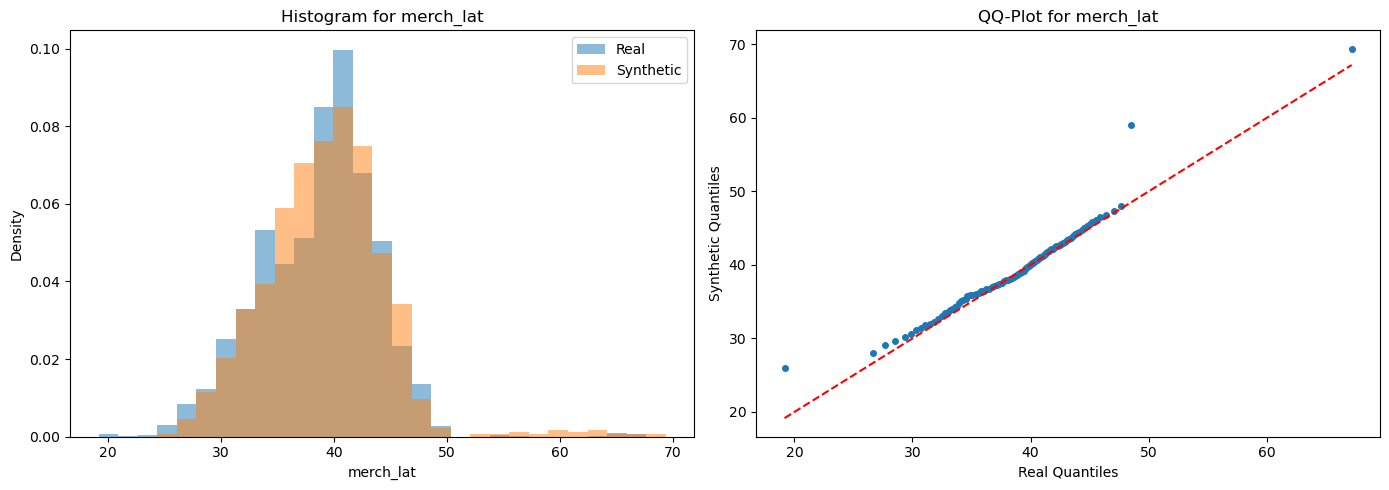


Feature: merch_long
  KS Statistic: 0.1122, p-value: 0.0000
  Wasserstein Distance: 3.2264
  Jensen-Shannon Divergence: 0.1736


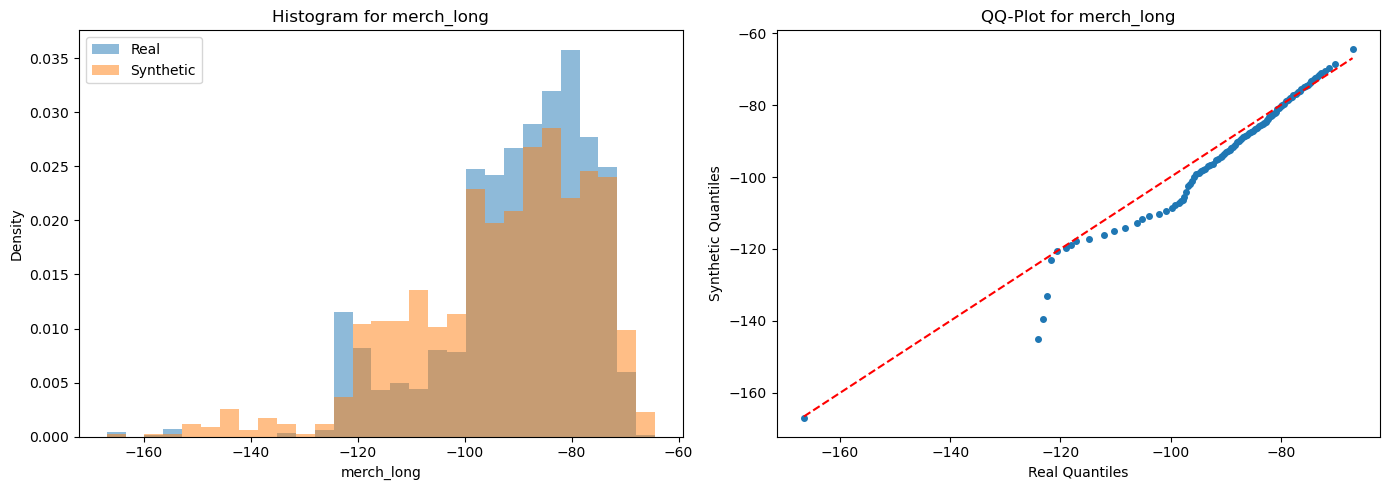

In [114]:
from scipy.stats import wasserstein_distance, ks_2samp
from scipy.spatial.distance import jensenshannon

def compare_distributions(real_numeric_df, synthetic_numeric_df):
    # Loop through each feature to compute statistics and plot comparisons
    for col in numeric_features:
        # Extract data for this feature from both real and synthetic datasets
        real_data = real_numeric_df[col].values
        syn_data = synthetic_numeric_df[col].values
        
        # 1. Kolmogorov–Smirnov test:
        ks_stat, ks_p = ks_2samp(real_data, syn_data)
        
        # 2. Wasserstein distance:
        wass_distance = wasserstein_distance(real_data, syn_data)
        
        # 3. Jensen–Shannon divergence:
        # Define common bins using the min and max of both distributions
        min_val = min(real_data.min(), syn_data.min())
        max_val = max(real_data.max(), syn_data.max())
        bins = np.linspace(min_val, max_val, 30)
        
        # Estimate PDFs (using normalized histograms)
        real_hist, _ = np.histogram(real_data, bins=bins, density=True)
        syn_hist, _ = np.histogram(syn_data, bins=bins, density=True)
        
        # Normalize to form proper probability distributions
        real_pdf = real_hist / real_hist.sum()
        syn_pdf = syn_hist / syn_hist.sum()
        
        jsd = jensenshannon(real_pdf, syn_pdf)

        # Print out the computed metrics for each feature
        print(f"\nFeature: {col}")
        print(f"  KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
        print(f"  Wasserstein Distance: {wass_distance:.4f}")
        print(f"  Jensen-Shannon Divergence: {jsd:.4f}")

        # Create a figure with two subplots: Histogram and QQ plot
        plt.figure(figsize=(14, 5))

        # Subplot 1: Histogram with density overlay
        plt.subplot(1, 2, 1)
        plt.hist(real_data, bins=bins, alpha=0.5, density=True, label='Real')
        plt.hist(syn_data, bins=bins, alpha=0.5, density=True, label='Synthetic')
        plt.title(f"Histogram for {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()

        # Subplot 2: QQ-Plot comparing quantiles
        plt.subplot(1, 2, 2)
        quantiles = np.linspace(0, 100, 100)
        real_quantiles = np.percentile(real_data, quantiles)
        syn_quantiles = np.percentile(syn_data, quantiles)
        plt.plot(real_quantiles, syn_quantiles, 'o', markersize=4)
        plt.plot([real_quantiles.min(), real_quantiles.max()],
                 [real_quantiles.min(), real_quantiles.max()], 'r--')
        plt.title(f"QQ-Plot for {col}")
        plt.xlabel("Real Quantiles")
        plt.ylabel("Synthetic Quantiles")
        
        plt.tight_layout()
        plt.show()

compare_distributions(real_numeric_df, synthetic_numeric_df)

In [115]:
len(synthetic_numeric_df[col].values)

1000